# Analysis of Public Interest on Initial Public Offering (IPO) on Bursa Malaysia

Initial Public Offering (IPO) is where shares of a company are offered to investors, both institutional and the public. Here I look at public interest towards IPO on Bursa Malaysia over the years.

Data was collected from the Internet 2017 till 2022. Data was collected manually: hence there could be errors in the numbers. Read that again. Data was collected manually: hence there could be errors in the numbers.

Only IPOs that can be subscribed by the public in the Main and ACE markets was included.

This is for entertainment purpose only. Do not trade shares based on this exercise. Trading shares involve capital loss and emotional pain. Please consult your investment advisor before embarking on any financial exercise.

In [1]:
import pandas as pd
from statistics import stdev
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("IPO_2017to2022.csv")
df.head()

,TICKER,MARKET,YEAR,LISTPRICE,VOLUMEIPODAY,OPENPRICEIPODAY,HIGHESTPRICEIPODAY,CLOSINGPRICEIPODAY,NEWSHARES,TOTALAPPLICATIONS,...,XBUMIAPPLICATIONS,XBUMIAPPLICATIONSHARES,XBUMIBALLOTINGOSCBED,ELIGPERSONSSHARES,PVPLACEMENTSHARES,OFFERFORSALE,CAPITALRAISED,PUBLICISSUENEWSHARES,ENLARGEDSHARECAPITAL,MARKETCAPONLISTING
0,CORAZA,ACE,2022,0.28,NaN,NaN,NaN,NaN,2140000.0,26781.0,...,14299.0,1.850000e+09,171.40,21400000.0,96400000.0,21400000.0,33000000.0,117800000.0,428300000.0,119900000.0
1,SENHENG,MAIN,2022,1.07,NaN,NaN,NaN,NaN,30000000.0,16548.0,...,9679.0,2.499200e+08,15.66,22500000.0,149500000.0,139500000.0,NaN,250000000.0,NaN,NaN
2,TUJUSETIA,MAIN,2021,0.70,1145707.0,0.775,0.875,0.74,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,YENHER,MAIN,2021,0.95,618271.0,0.995,1.000,0.90,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CTOS,MAIN,2021,1.10,3663593.0,1.500,1.760,1.62,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Create following columns:
# % difference between list price vs opening price on IPO day
# % difference between list price vs highest price on IPO day
# % difference between opening price on IPO day vs closing price on IPO day
# % difference between opening price on IPO day vs highest price on IPO day

df['LISTVSOPENING_PCT'] = df['OPENPRICEIPODAY']/df['LISTPRICE']*100 - 100
df['LISTVSHIGHEST_PCT'] = df['HIGHESTPRICEIPODAY']/df['LISTPRICE']*100 - 100
df['LISTVSCLOSING_PCT'] = df['CLOSINGPRICEIPODAY']/df['LISTPRICE']*100 - 100

In [4]:
# remove Lotte Chemical as it was undersubscribed
df = df[df['TICKER']!='LOTTE']

In [5]:
df.shape

(66, 28)

In [6]:
# grab all available years
years = df['YEAR'].unique().tolist()[::-1]
years

[2017, 2018, 2019, 2020, 2021, 2022]

## Measuring Subscription Interest: Oversubscription Rate by Year

Question: how does public interest towards IPOs change over the years?

### Aggregate, all combined (regardless listing price)

In [7]:
barheight = []
barerr = []

for year in years:
    df_series = df[((df['YEAR']==year))]['TOTALBALLOTINGOSCBED'].dropna()
    count = df_series.count()

    median_year = round(df_series.median(),2)
    mean_year = round(df_series.mean(),2)
    min_year = df_series.min()
    max_year = df_series.max()
    print(str(year) + '(' + str(count) + '): median ' + str(median_year) + ', mean ' + str(mean_year) + 
         ', min ' + str(min_year) + ', max ' + str(max_year))
        
    barheight.append(mean_year)
    barerr.append(stdev(df_series))

2017(10): median 17.46, mean 27.12, min 4.21, max 65.0
2018(11): median 16.35, mean 16.61, min 1.16, max 43.0
2019(15): median 9.41, mean 12.06, min 3.64, max 35.0
2020(11): median 15.9, mean 28.52, min 3.91, max 82.0
2021(17): median 42.07, mean 65.81, min 13.8, max 176.6
2022(2): median 71.47, mean 71.47, min 10.44, max 132.5


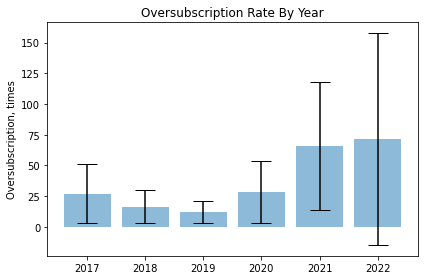

In [8]:
fig, ax = plt.subplots()
xpos = np.arange(len(barheight))
ax.bar(xpos, barheight, yerr=barerr, align='center',
       alpha=0.5, ecolor='black', capsize=10)
ax.set_xticks(xpos)
ax.set_xticklabels(years)
ax.set_ylabel('Oversubscription, times')
plt.title('Oversubscription Rate By Year')

plt.tight_layout()
plt.show()

From 2017 till 2020 public interest was about the same. With a bit of dip in 2019. In 2021 and 2022 there is a significant increase in public appetite towards IPO.
(Nevermind the big standard deviation lines, it's just there for the sake of it)

### For listing price at least RM1.00

In [9]:
print("IPO Oversubscription by year, for listing price >= RM1.00 :")
for year in years:
    df_series = df[((df['YEAR']==year)  & (df['LISTPRICE']>=1))]['TOTALBALLOTINGOSCBED']
    count = df_series.count()

    median_year = round(df_series.median(),2)
    mean_year = round(df_series.mean(),2)
    min_year = df_series.min()
    max_year = df_series.max()
    print(str(year) + '(' + str(count) + '): median ' + str(median_year) + ', mean ' + str(mean_year) + 
         ', min ' + str(min_year) + ', max ' + str(max_year))

IPO Oversubscription by year, for listing price >= RM1.00 :
2017(3): median 5.07, mean 6.34, min 4.96, max 9.0
2018(1): median 1.16, mean 1.16, min 1.16, max 1.16
2019(2): median 4.01, mean 4.01, min 3.64, max 4.39
2020(1): median 3.91, mean 3.91, min 3.91, max 3.91
2021(3): median 20.27, mean 22.23, min 18.85, max 27.57
2022(1): median 10.44, mean 10.44, min 10.44, max 10.44


I suppose no point really to plot them since the numbers per year are too few.

### For listing price below RM1.00

In [10]:
barheight = []
barerr = []
for year in years:
    df_series = df[((df['YEAR']==year)  & (df['LISTPRICE']<1))]['TOTALBALLOTINGOSCBED']
    count = df_series.count()

    median_year = round(df_series.median(),2)
    mean_year = round(df_series.mean(),2)
    min_year = df_series.min()
    max_year = df_series.max()
    print(str(year) + '(' + str(count) + '): median ' + str(median_year) + ', mean ' + str(mean_year) + 
         ', min ' + str(min_year) + ', max ' + str(max_year))
    
    barheight.append(mean_year)
    if count >1:
        barerr.append(stdev(df_series))
    else:
        barerr.append(0)

2017(7): median 42.74, mean 36.03, min 4.21, max 65.0
2018(10): median 17.68, mean 18.15, min 2.84, max 43.0
2019(13): median 11.34, mean 13.3, min 3.84, max 35.0
2020(10): median 20.09, mean 30.98, min 10.5, max 82.0
2021(14): median 66.56, mean 75.15, min 13.8, max 176.6
2022(1): median 132.5, mean 132.5, min 132.5, max 132.5


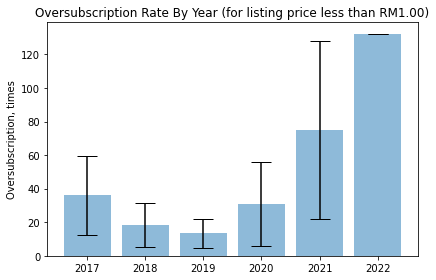

In [11]:
fig, ax = plt.subplots()
xpos = np.arange(len(barheight))
ax.bar(xpos, barheight, yerr=barerr, align='center',
       alpha=0.5, ecolor='black', capsize=10)
ax.set_xticks(xpos)
ax.set_xticklabels(years)
ax.set_ylabel('Oversubscription, times')
plt.title('Oversubscription Rate By Year (for listing price less than RM1.00)')

plt.tight_layout()
plt.show()

## Measuring Speculative Activity on IPO Day: Volume on IPO day by Year
Question: If there is an increase in public interest, does this translate into higher trading volume on the counter on IPO day?
Potential scenario is that there are more capital/participants involved on the counter on the IPO day, other than those originally succesfully subscribed to the IPO.

### Aggregate, all combined (regardless listing price)

In [12]:
# remove 2022 for now
del years[-1]

In [13]:
print("Volume on IPO day by year:")

barheight = []
barerr = []

for year in years:
    df_series = df[((df['YEAR']==year))]['VOLUMEIPODAY']
    count = df_series.count()

    median_year = round(df_series.median())
    mean_year = round(df_series.mean())
    min_year = round(df_series.min())
    max_year = round(df_series.max())
    print(str(year) + '(' + str(count) + '): median ' + str(median_year) + ', mean ' + str(mean_year) + 
         ', min ' + str(min_year) + ', max ' + str(max_year))
    
    barheight.append(mean_year)
    if count >1:
        barerr.append(stdev(df_series))
    else:
        barerr.append(0)

Volume on IPO day by year:
2017(10): median 698868, mean 909952, min 4054, max 3039148
2018(11): median 828043, mean 985777, min 38240, max 1882969
2019(15): median 1185984, mean 1602266, min 298350, max 4479182
2020(11): median 2070206, mean 2233225, min 1068858, max 4101546
2021(17): median 1501863, mean 1722855, min 472273, max 3663593


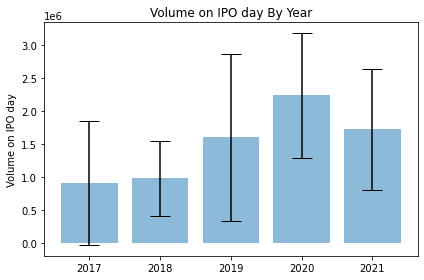

In [14]:
fig, ax = plt.subplots()
xpos = np.arange(len(barheight))
ax.bar(xpos, barheight, yerr=barerr, align='center',
       alpha=0.5, ecolor='black', capsize=10)
ax.set_xticks(xpos)
ax.set_xticklabels(years)
ax.set_ylabel('Volume on IPO day')
plt.title('Volume on IPO day By Year')

plt.tight_layout()
plt.show()

2020 seems to be the year with the most liquidity, despite being not the year with the highest oversubscription rate

### For listing price at least RM1.00:

In [15]:
print("Volume on IPO day by year, for listing price >=RM1.00:")
for year in years:
    df_series = df[((df['YEAR']==year) & (df['LISTPRICE']>=1))]['VOLUMEIPODAY']
    count = df_series.count()

    median_year = round(df_series.median())
    mean_year = round(df_series.mean())
    min_year = round(df_series.min())
    max_year = round(df_series.max())
    print(str(year) + '(' + str(count) + '): median ' + str(median_year) + ', mean ' + str(mean_year) + 
         ', min ' + str(min_year) + ', max ' + str(max_year))


Volume on IPO day by year, for listing price >=RM1.00:
2017(3): median 182410, mean 282242, min 4054, max 660261
2018(1): median 736832, mean 736832, min 736832, max 736832
2019(2): median 1325753, mean 1325753, min 497515, max 2153991
2020(1): median 4101546, mean 4101546, min 4101546, max 4101546
2021(3): median 1870413, mean 2373199, min 1585591, max 3663593


### For listing price less than RM1.00:

In [16]:
print("Volume on IPO day by year, for listing price <RM1.00:")

barheight = []
barerr = []

for year in years:
    df_series = df[((df['YEAR']==year) & (df['LISTPRICE']<1))]['VOLUMEIPODAY']
    count = df_series.count()

    median_year = round(df_series.median())
    mean_year = round(df_series.mean())
    print(str(year) + '(' + str(count) + '): median ' + str(median_year) + ', mean ' + str(mean_year))
    
    barheight.append(mean_year)
    if count >1:
        barerr.append(stdev(df_series))
    else:
        barerr.append(0)

Volume on IPO day by year, for listing price <RM1.00:
2017(7): median 1264232, mean 1178971
2018(10): median 853624, mean 1010671
2019(13): median 1185984, mean 1644806
2020(10): median 1981470, mean 2046393
2021(14): median 1300062, mean 1583495


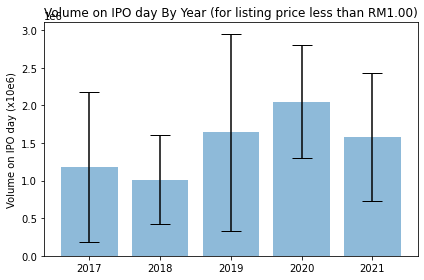

In [17]:
fig, ax = plt.subplots()
xpos = np.arange(len(barheight))
ax.bar(xpos, barheight, yerr=barerr, align='center',
       alpha=0.5, ecolor='black', capsize=10)
ax.set_xticks(xpos)
ax.set_xticklabels(years)
ax.set_ylabel('Volume on IPO day (x10e6)')
plt.title('Volume on IPO day By Year (for listing price less than RM1.00)')

plt.tight_layout()
plt.show()

## Measuring Speculative Activity on IPO Day: % Difference between Listing vs Opening Price

In [18]:
barheight = []
barerr = []

for year in years:
    df_series = df[((df['YEAR']==year))]['LISTVSOPENING_PCT']
    count = df_series.count()

    median_year = round(df_series.median(),2)
    mean_year = round(df_series.mean(),2)
    min_year = round(df_series.min())
    max_year = round(df_series.max())
    print(str(year) + '(' + str(count) + '): median ' + str(median_year) + ', mean ' + str(mean_year) + 
         ', min ' + str(min_year) + ', max ' + str(max_year))
    
    barheight.append(mean_year)
    if count >1:
        barerr.append(stdev(df_series))
    else:
        barerr.append(0)

2017(10): median 19.44, mean 17.91, min 2, max 32
2018(11): median 21.97, mean 30.31, min -18, max 117
2019(15): median 13.04, mean 22.67, min -9, max 113
2020(11): median 23.21, mean 50.81, min -1, max 154
2021(17): median 25.0, mean 59.9, min -29, max 245


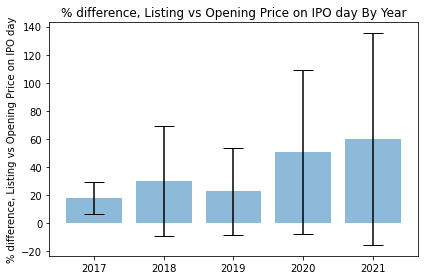

In [19]:
fig, ax = plt.subplots()
xpos = np.arange(len(barheight))
ax.bar(xpos, barheight, yerr=barerr, align='center',
       alpha=0.5, ecolor='black', capsize=10)
ax.set_xticks(xpos)
ax.set_xticklabels(years)
ax.set_ylabel('% difference, Listing vs Opening Price on IPO day')
plt.title('% difference, Listing vs Opening Price on IPO day By Year')

plt.tight_layout()
plt.show()

There is a general trend that over the years, we can see higher price at market open compared to previous years

## Measuring Speculative Activity on IPO Day: % Difference between Listing vs Highest Price

In [20]:
barheight = []
barerr = []

for year in years:
    df_series = df[((df['YEAR']==year))]['LISTVSHIGHEST_PCT']
    count = df_series.count()

    median_year = round(df_series.median(),2)
    mean_year = round(df_series.mean(),2)
    min_year = round(df_series.min())
    max_year = round(df_series.max())
    print(str(year) + '(' + str(count) + '): median ' + str(median_year) + ', mean ' + str(mean_year) + 
         ', min ' + str(min_year) + ', max ' + str(max_year))

    barheight.append(mean_year)
    if count >1:
        barerr.append(stdev(df_series))
    else:
        barerr.append(0)

2017(10): median 26.25, mean 22.86, min 4, max 36
2018(11): median 34.09, mean 51.41, min -9, max 183
2019(15): median 27.87, mean 32.22, min -9, max 130
2020(11): median 55.36, mean 69.99, min 6, max 163
2021(17): median 36.03, mean 76.09, min -13, max 260


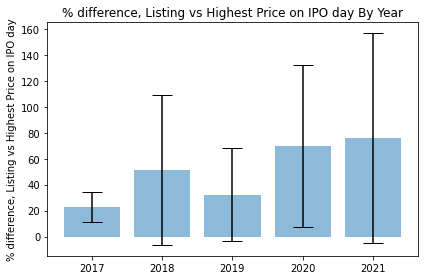

In [21]:
fig, ax = plt.subplots()
xpos = np.arange(len(barheight))
ax.bar(xpos, barheight, yerr=barerr, align='center',
       alpha=0.5, ecolor='black', capsize=10)
ax.set_xticks(xpos)
ax.set_xticklabels(years)
ax.set_ylabel('% difference, Listing vs Highest Price on IPO day')
plt.title('% difference, Listing vs Highest Price on IPO day By Year')

plt.tight_layout()
plt.show()

Also, there is a general trend we can see higher price at during trading day compared to previous years.

## Does high public interest during subscription translate into higher activity on IPO day?

In [22]:
# drop 2022 as we no IPOs yet
df = df[df['YEAR']!=2022]

### Plot oversubscription vs volume

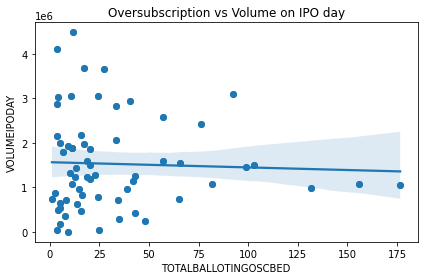

In [23]:
x_label = 'TOTALBALLOTINGOSCBED'
y_label = 'VOLUMEIPODAY'
x = df[x_label]
y = df[y_label]
fig, ax = plt.subplots()
ax.scatter(x,y)

sns.regplot(x, y)

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)

plt.title('Oversubscription vs Volume on IPO day')
plt.tight_layout()
plt.show()

In [24]:
m, b, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print("R2: ", round(r_value,4))
print("P-value: ", round(p_value,4))
print("stderr: ", round(std_err,4))

R2:  -0.0414
P-value:  0.7451
stderr:  3584.2066


Doesn't look like there's any correlation: high interest in subscription activity does not translate into high volume on IPO day per se.

## Does high public interest during subscription translate into higher speculative activity on IPO day?
i.e, does high public interest push up the price (despite having no increase in volume)?

### Plot oversubscription vs %difference listing-to-opening price

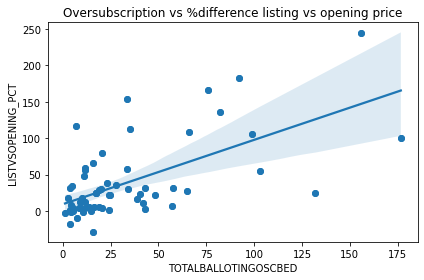

In [25]:
x_label = 'TOTALBALLOTINGOSCBED'
y_label = 'LISTVSOPENING_PCT'
x = df[x_label]
y = df[y_label]
fig, ax = plt.subplots()
ax.scatter(x,y)

sns.regplot(x, y)

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)

plt.title('Oversubscription vs %difference listing vs opening price')
plt.tight_layout()
plt.show()

In [26]:
m, b, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print("R2: ", round(r_value,4))
print(f"P-value: {p_value:.4e}")
print("stderr: ", round(std_err,4))
print("equation: y = " + str(round(m,4)) + "*X + " + str(round(b,4)))

R2:  0.6233
P-value: 3.7707e-08
stderr:  0.1409
equation: y = 0.8844*X + 9.3979


Looks like there's a correlation: the higher public interest in subscribing to the IPO (as measured by the oversubscription rate), the higher likelihood that we'd see higher opening price on IPO day.

This tells you that while there is no correlation between oversubscription with volume per se, the ones that participate during IPO day indeed push up the price at market open.

##### Remove points with oversubscription more than 40X, to see if the result is robust for lower oversubscription data points

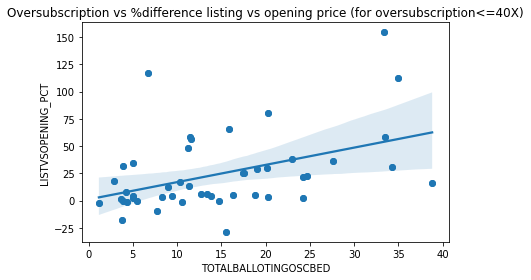

In [27]:
df2 = df[df['TOTALBALLOTINGOSCBED']<40]

x_label = 'TOTALBALLOTINGOSCBED'
y_label = 'LISTVSOPENING_PCT'
x = df2[x_label]
y = df2[y_label]
fig, ax = plt.subplots()
ax.scatter(x,y)

sns.regplot(x, y)

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)

plt.title('Oversubscription vs %difference listing vs opening price (for oversubscription<=40X)')
plt.tight_layout()
plt.show()


In [28]:
m, b, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print("R2: ", round(r_value,4))
print(f"P-value: {p_value:.4e}")
print("stderr: ", round(std_err,4))
print("equation: y = " + str(round(m,4)) + "*X + " + str(round(b,4)))

R2:  0.4376
P-value: 2.0994e-03
stderr:  0.4849
equation: y = 1.5829*X + 1.1793


Yes, the result still holds, albeit with slightly lower R2 value

### Plot oversubscription vs %difference listing-to-highest price

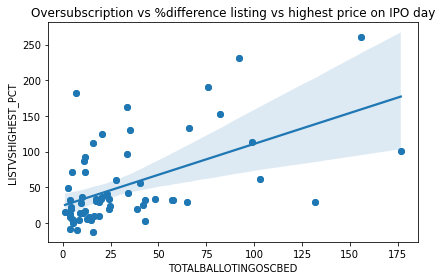

In [29]:
x_label = 'TOTALBALLOTINGOSCBED'
y_label = 'LISTVSHIGHEST_PCT'
x = df[x_label]
y = df[y_label]
fig, ax = plt.subplots()
ax.scatter(x,y)

sns.regplot(x, y)

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)

plt.title('Oversubscription vs %difference listing vs highest price on IPO day')
plt.tight_layout()
plt.show()

In [30]:
m, b, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print("R2: ", round(r_value,4))
print(f"P-value: {p_value:.4e}")
print("stderr: ", round(std_err,4))
print("equation: y = " + str(round(m,4)) + "*X + " + str(round(b,4)))

R2:  0.5375
P-value: 4.6445e-06
stderr:  0.1724
equation: y = 0.8654*X + 24.2476


Also, the higher public interest in subscribing to the IPO (as measured by the oversubscription rate), the higher likelihood that the price will be pushed to a really high level on IPO day.

So, again, high public interest to the IPO does not translate into more volume, but those that participate during the IPO day push up the price at market open, and also push up the price to a high level during the day.

In [31]:
#### Again, check for oversubscription <=40X

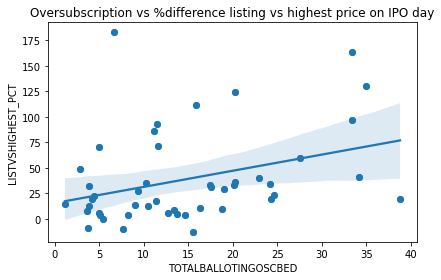

In [32]:
df2 = df[df['TOTALBALLOTINGOSCBED']<=40]
x_label = 'TOTALBALLOTINGOSCBED'
y_label = 'LISTVSHIGHEST_PCT'
x = df2[x_label]
y = df2[y_label]
fig, ax = plt.subplots()
ax.scatter(x,y)

sns.regplot(x, y)

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)

plt.title('Oversubscription vs %difference listing vs highest price on IPO day')
plt.tight_layout()
plt.show()

In [33]:
m, b, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print("R2: ", round(r_value,4))
print(f"P-value: {p_value:.4e}")
print("stderr: ", round(std_err,4))
print("equation: y = " + str(round(m,4)) + "*X + " + str(round(b,4)))

R2:  0.3455
P-value: 1.7366e-02
stderr:  0.6392
equation: y = 1.5789*X + 15.6509


Result holds

### plot oversubscription vs %difference listing-to-closing price

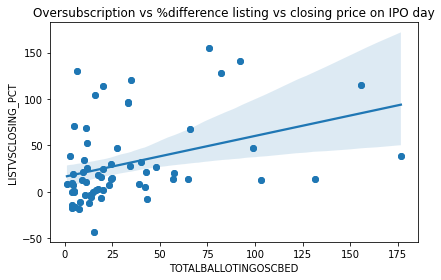

In [34]:
x_label = 'TOTALBALLOTINGOSCBED'
y_label = 'LISTVSCLOSING_PCT'
x = df[x_label]
y = df[y_label]
fig, ax = plt.subplots()
ax.scatter(x,y)

sns.regplot(x, y)

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)

plt.title('Oversubscription vs %difference listing vs closing price on IPO day')
plt.tight_layout()
plt.show()

In [35]:
m, b, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print("R2: ", round(r_value,4))
print(f"P-value: {p_value:.4e}")
print("stderr: ", round(std_err,4))
print("equation: y = " + str(round(m,4)) + "*X + " + str(round(b,4)))

R2:  0.364
P-value: 3.1082e-03
stderr:  0.1426
equation: y = 0.4387*X + 16.4226


So, again, high public interest to the IPO does not translate into more volume, but those that participate during the IPO day push up the price at market open, and also push up the price to a high level during the day.

#### Verify for oversubscription less than 40X

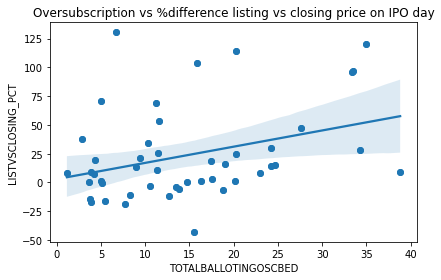

In [36]:
df = df[df['TOTALBALLOTINGOSCBED']<=40]
x_label = 'TOTALBALLOTINGOSCBED'
y_label = 'LISTVSCLOSING_PCT'
x = df[x_label]
y = df[y_label]
fig, ax = plt.subplots()
ax.scatter(x,y)

sns.regplot(x, y)

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)

plt.title('Oversubscription vs %difference listing vs closing price on IPO day')
plt.tight_layout()
plt.show()

In [39]:
m, b, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print("R2: ", round(r_value,4))
print("P-value: ", round(p_value,4))
print("stderr: ", round(std_err,4))
print("equation: y = " + str(round(m,4)) + "*X + " + str(round(b,4)))

R2:  0.3451
P-value:  0.0175
stderr:  0.5712
equation: y = 1.409*X + 2.9492


Result holds, albeit with bit worse P-value.

## Summary
1. There's more interest from the public for IPO in recent years
    - with a general trend that we see higher price at market open and during trading day vs previous years.
2. Year 2020 we see the market is flush with liquidity, as there is high volume on an IPO counter.
3. Higher oversubscription rate does not translate into higher volume on IPO day
4. Yet, higher oversubscription rate correlates with:
    - higher price at market open
    - higher price during trading day
    - higher price at market close

## More Questions
1. The higher interest from the public, is it both from the Bumis as well as non-Bumis?
2. ...
3. ...